**Importing Required Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

# Data merging

In [2]:
# Define the directory containing the Excel files
dir_path = r'D:\Project II\Survey\Survey_Data\\'

# Initialize empty DataFrames for Route1 and Route2
combined_route1 = pd.DataFrame()
combined_route2 = pd.DataFrame()

# Loop through all files in the directory
for file_name in os.listdir(dir_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(dir_path, file_name)
        
        # Read the Route1 and Route2 sheets from the current file
        route1_df = pd.read_excel(file_path, sheet_name='Route1', header = 2, usecols='A:M')
        route2_df = pd.read_excel(file_path, sheet_name='Route2', header = 2, usecols='A:M')
        # Drop rows where 'Bus Start Time' is empty (NaN or None)
        route1_df = route1_df.dropna(subset=['Bus Start Time'])
        route2_df = route2_df.dropna(subset=['Bus Start Time'])
        
        # Append the data to the combined DataFrames
        combined_route1 = pd.concat([combined_route1, route1_df], ignore_index=True)
        combined_route2 = pd.concat([combined_route2, route2_df], ignore_index=True)

# Define the output file path
output_file_path = os.path.join(dir_path, 'Combined_Survey_Data.xlsx')

# Write the combined DataFrames to a new Excel file with two sheets
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    combined_route1.to_excel(writer, sheet_name='Route1', index=False)
    combined_route2.to_excel(writer, sheet_name='Route2', index=False)

print(f"Combined data saved to {output_file_path}")

Combined data saved to D:\Project II\Survey\Survey_Data\\Combined_Survey_Data.xlsx


# Data Wrangling
Extract time components, calculate total travel time in minutes, and derive "Mean Travel Time" by subtracting dwell delays. This prepares features for aggregation and modeling.

In [3]:
file_path = r'D:\Project II\Survey\Survey_Data\Combined_Survey_Data.xlsx'

def process_route(df):
    df = df.copy()

    df['Start_Time_only'] = df['Bus Start Time'].dt.time
    df['Travel Time'] = df['Bus End Time'] - df['Bus Start Time']
    df['Travel Time(min)'] = df['Travel Time'].dt.total_seconds() / 60

    delay_cols = ['Dbs', 'Duc', 'Di', 'Dar', 'Dut', 'Dpc', 'Df']
    df['Mean Travel Time'] = ( df['Travel Time'].dt.total_seconds() - df[delay_cols].sum(axis=1))
    return df

route1_df = process_route(pd.read_excel(file_path, sheet_name='Route1'))
route2_df = process_route(pd.read_excel(file_path, sheet_name='Route2'))

# Output
dir_path = r'D:\Project II\Survey\Survey_Data'
output_file_path = os.path.join(dir_path, 'Final_Survey_data.xlsx')
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    route1_df.to_excel(writer, sheet_name='Route1', index=False)
    route2_df.to_excel(writer, sheet_name='Route2', index=False)

### Data Aggregation
Group data into 30-minute time bins and 95th percentiles travel times. The 95th percentile represents "Planning Time" (worst-case scenario for reliability).

In [4]:
file_path = r'D:\Project II\Survey\Data Extraction\Final_Survey_data.xlsx'
dir_path = r'D:\Project II\Survey\Data Extraction'

# Columns to average
columns_to_average = ['Dbs', 'Duc', 'Di', 'Dar', 'Dut', 'Dpc', 'Df', 'Mean Travel Time']
group_size = 4

def process_route(df):
    df = df.copy()
    
    # Create groups of 4 rows
    df['Group'] = df.index // group_size
    
    # Aggregate
    result = df.groupby('Group').agg({
        **{col: 'mean' for col in columns_to_average},
        'Travel Time(min)': lambda x: x.quantile(0.95)
    }).reset_index()
    
    # Convert to seconds and rename
    result['Planning Time'] = result['Travel Time(min)'] * 60
    result.drop(columns='Travel Time(min)', inplace=True)
    
    return result

# Read sheets dynamically
routes = {
    'Route1': pd.read_excel(file_path, sheet_name='Route1'),
    'Route2': pd.read_excel(file_path, sheet_name='Route2')
}

output_file_path = os.path.join(dir_path, 'Grouped_data.xlsx')

with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for route_name, df in routes.items():
        processed_df = process_route(df)
        processed_df.to_excel(writer, sheet_name=route_name, index=False)

print("File saved successfully as 'Grouped_data.xlsx'")


File saved successfully as 'Grouped_data.xlsx'


# Exploratory Data Analysis

                  Mean (minutes)  Standard Deviation (minutes)
Dbs                         6.94                          1.88
Duc                         2.73                          0.65
Di                          5.82                          2.18
Dar                         2.04                          1.14
Dut                         0.17                          0.17
Dpc                         0.44                          0.26
Df                          0.73                          0.56
Mean Travel Time           64.25                          5.02
Planning Time              90.51                          6.85


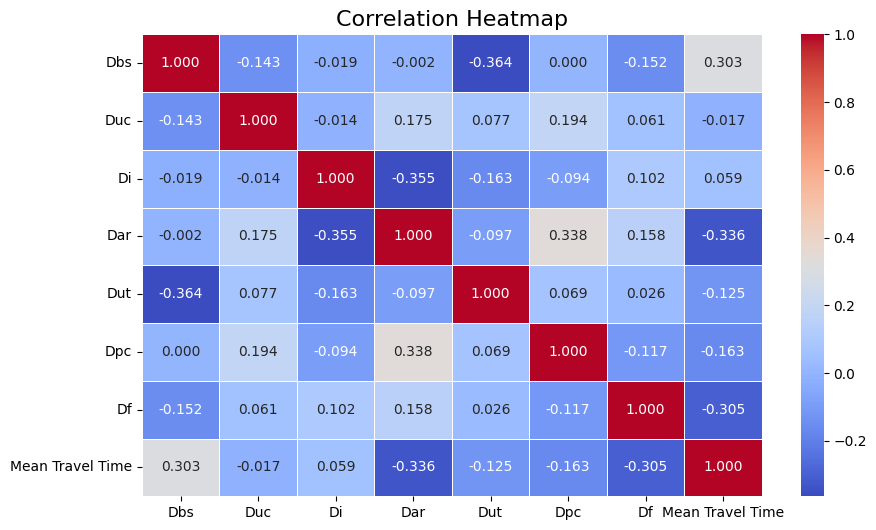

In [5]:
input_file_path = r'D:\Project II\Survey\Data Extraction\Grouped_data.xlsx'
output_dir = r'D:\Project II\Survey\Data Extraction'
routes = ['Route1', 'Route2']

dfs = []
for route in routes:
    df_route = pd.read_excel(input_file_path, sheet_name=route)
    df_route = df_route.drop(columns='Group')  # Remove grouping index
    dfs.append(df_route)

# Combined dataset for analysis
df = pd.concat(dfs, ignore_index=True)

# Calculate mean and standard deviation
mean_seconds = df.mean()
std_seconds = df.std()

# Convert from seconds to minutes
mean_minutes = mean_seconds / 60
std_minutes = std_seconds / 60

# Summary table
summary_df = pd.DataFrame({
    'Mean (minutes)': mean_minutes.round(2),
    'Standard Deviation (minutes)': std_minutes.round(2)
})

print(summary_df)
summary_df.to_clipboard(excel=True)
summary_df.to_excel("mean-std.xlsx", sheet_name="Summary")

# --------------------------------------------------
# CORRELATION ANALYSIS
# --------------------------------------------------
# Exclude Planning Time to avoid correlation with derived variable
df_corr = df.drop(columns=['Planning Time'])

correlation_matrix = df_corr.corr().round(3)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)

# Title for the heatmap
plt.title("Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()
correlation_matrix.to_excel("correlation_matrix.xlsx", sheet_name="Summary")

# Linear Regression Model

## Initial Full Model (All Predictors)
Fit OLS regression using all dwell variables to predict Planning Time. This baseline identifies significant predictors (p < 0.05) via the model summary.

In [6]:
# Define independent (X) and dependent (Y) variables
X = df[['Dbs', 'Duc', 'Di', 'Dar', 'Dut', 'Dpc', 'Df', 'Mean Travel Time']]
Y = df['Planning Time']  # No double brackets to keep it as a Series

# 1. Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)



# 2. Fit the model on the training data
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())
# 3. Calculate R² for the training data
train_r_squared = model.rsquared

# 4. Calculate R² for the test data
Y_pred = model.predict(X_test)
test_r_squared = 1 - (np.sum((Y_test - Y_pred)**2) / np.sum((Y_test - np.mean(Y_test))**2))

print(f"Training R²: {train_r_squared}")
print(f"Test R²: {test_r_squared}")

                                 OLS Regression Results                                
Dep. Variable:          Planning Time   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              1318.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):                    3.45e-22
Time:                        17:01:19   Log-Likelihood:                         -170.06
No. Observations:                  25   AIC:                                      356.1
Df Residuals:                      17   BIC:                                      365.9
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Final Reduced Model (Significant Predictors Only)
Remove non-significant variables (e.g., Duc, Dut, Dpc based on p-values > 0.05) to create a simpler, more interpretable model while maintaining fit (Adjusted R²).

In [7]:
# Define independent (X) and dependent (Y) variables
X = df[['Dbs',  'Di', 'Dar', 'Df', 'Mean Travel Time']]
Y = df['Planning Time']  # No double brackets to keep it as a Series

# 1. Split the data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)



# 2. Fit the model on the training data
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())
# 3. Calculate R² for the training data
train_r_squared = model.rsquared

# 4. Calculate R² for the test data
Y_pred = model.predict(X_test)
test_r_squared = 1 - (np.sum((Y_test - Y_pred)**2) / np.sum((Y_test - np.mean(Y_test))**2))

print(f"Training R²: {train_r_squared}")
print(f"Test R²: {test_r_squared}")

                                 OLS Regression Results                                
Dep. Variable:          Planning Time   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              2064.
Date:                Wed, 14 Jan 2026   Prob (F-statistic):                    2.07e-26
Time:                        17:01:19   Log-Likelihood:                         -172.35
No. Observations:                  25   AIC:                                      354.7
Df Residuals:                      20   BIC:                                      360.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

**Regression Equation**

In [8]:
coefs = model.params
equation = "Planning Time = " + " + ".join(f"{coefs[i]:.4f}*{col}" for i, col in enumerate(X.columns))
print("Regression Equation:\n", equation)

Regression Equation:
 Planning Time = 0.9657*Dbs + 1.1513*Di + 1.7089*Dar + 4.7486*Df + 1.0934*Mean Travel Time


C:\Users\ACER\AppData\Local\Temp\ipykernel_20872\4165553047.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = "Planning Time = " + " + ".join(f"{coefs[i]:.4f}*{col}" for i, col in enumerate(X.columns))


# Model Evaluation

**MAPE Calculation**

In [9]:
# Creating a DataFrame to store real values, predicted values, and percentage change
results_df = pd.DataFrame({
    'Field Planning Time': Y_test,
    'Predicted Planning Time': Y_pred
})

# 1. Calculate the percentage change between real and predicted values
results_df['% Change'] = ((results_df['Predicted Planning Time'] - results_df['Field Planning Time']) / results_df['Field Planning Time']) * 100

# 2. Calculate the MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(Y_test, Y_pred)

# Display the results
print("Result of Validation of Model")
print(results_df)

print(f"\nMean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Result of Validation of Model
    Field Planning Time  Predicted Planning Time   % Change
27              6391.10              6287.368455  -1.623062
3               5422.05              5405.841242  -0.298942
22              5542.05              5857.006226   5.683028
18              4898.45              5406.205838  10.365643
23              5126.80              4915.888575  -4.113900
17              4938.35              5089.191116   3.054484
21              6074.30              5725.699497  -5.738941

Mean Absolute Percentage Error (MAPE): 4.41%


**Training Data Table**

In [10]:
# Combine training features and target into one DataFrame
train_data = pd.concat([X_train, Y_train], axis=1)
train_data = (train_data / 60).round(3)

# Display the entire training data
print("Training Data:")
print(train_data.to_string(index=False))  # to_string() shows full table

Training Data:
   Dbs     Di   Dar    Df  Mean Travel Time  Planning Time
11.258  5.842 1.154 0.296            68.296         92.949
 7.429  0.796 1.962 0.542            64.179         83.952
 9.650  5.371 2.033 0.900            70.888         98.981
 7.842  8.137 0.621 0.146            64.921         96.159
 6.662  5.283 1.817 0.512            61.200         83.112
 7.642  4.996 5.000 0.308            57.567         86.210
 4.862  7.617 0.742 1.025            72.733         98.988
 5.225  4.325 2.754 0.467            66.404         87.284
 7.329 10.579 1.604 2.796            55.158         90.452
 9.258  7.679 1.804 0.396            64.071         99.349
 8.196  6.308 1.767 0.612            65.471         90.458
 6.162  4.800 2.167 1.421            65.712         88.971
 7.300  5.088 4.588 1.600            66.225        102.867
 7.142  9.042 0.804 0.225            68.904         97.408
 4.604  9.129 1.267 0.425            59.867         80.253
 6.308  1.575 3.988 0.638            64.6

**Test Data Table**

In [11]:
# Combine test features and target into one DataFrame
test_data = pd.concat([X_test, Y_test], axis=1)
test_data = (test_data / 60).round(3)
# Display the entire test data
print("\nTest Data:")
print(test_data.to_string(index=False))


Test Data:
  Dbs    Di   Dar    Df  Mean Travel Time  Planning Time
9.212 6.629 0.871 0.300            78.054        106.518
6.638 4.746 1.483 0.546            66.850         90.367
6.562 8.154 1.621 0.746            69.121         92.367
8.033 2.550 2.067 1.379            63.404         81.641
3.025 3.388 1.138 0.854            63.204         85.447
9.908 4.375 1.462 0.192            61.096         82.306
8.746 5.392 1.208 0.900            68.075        101.238
